In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'input/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [00:03<00:00, 3061.83it/s]


In [3]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',   
#     patience=5,          
#     verbose=1,          
#     factor=0.5,          
#     min_lr=0.00001       
# )

# learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.1,  # Initial learning rate for training
#     decay_steps=1000,            # Number of steps before decaying the learning rate
#     decay_rate=0.5,              # Rate at which the learning rate decreases
# )

# lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [13]:
# defining the model

model = models.Sequential()


model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(80, 2)))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(80, 2)))
model.add(layers.MaxPooling1D(pool_size=2))

# model.add(layers.GRU(16, input_shape=(80,2)))

model.add(layers.Flatten())


model.add(layers.Dense(16))
model.add(layers.Dense(16))

model.add(layers.Dense(1))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam')


history = model.fit(x_train, y_train, validation_split=.1, epochs=10, batch_size=16, verbose=1, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 4s 7ms/step - loss: 7.6197 - val_loss: 1.3241e-05
Epoch 2/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0982 - val_loss: 2.5307e-05
Epoch 3/10
422/422 [==============================] - 3s 6ms/step - loss: 0.0764 - val_loss: 1.2597e-05
Epoch 4/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0492 - val_loss: 2.6854e-04
Epoch 5/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0374 - val_loss: 3.0565e-06
Epoch 6/10
422/422 [==============================] - 3s 6ms/step - loss: 0.0121 - val_loss: 3.9126e-06


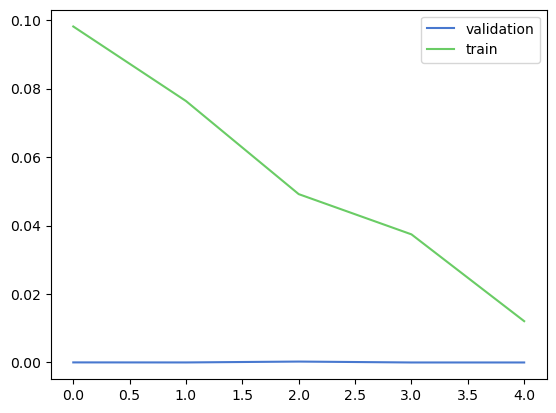

In [14]:
plt.plot(history.history['val_loss'][1:], label='validation')
plt.plot(history.history['loss'][1:], label='train')

plt.legend()
plt.show()

Dummy variables just for visualization purposes

In [15]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)



79/79 [==============================] - 0s 2ms/step


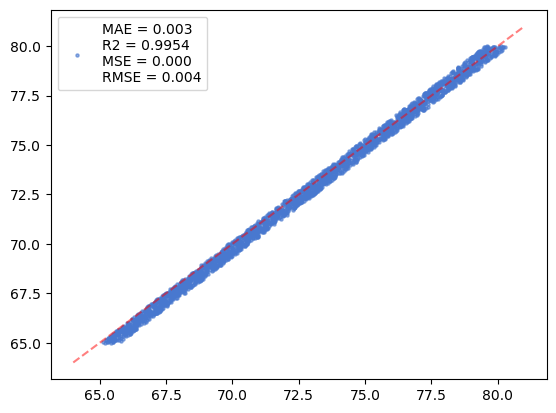

In [16]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.31, .315, 2500)


plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'MAE = {mae:.3f}\nR2 = {r2:.4f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()
plt.savefig("imagens/metrics_h0_cnn")
plt.show()

In [17]:
# forecasting "real" H(0)

real = np.load('input/data_real80.npy')
real = real[real[:, 1].argsort()]

real = real.reshape(-1,80,2)

In [18]:

final_real = model.predict(real, verbose=0)

In [19]:
final_real*norm

array([[67.73961]], dtype=float32)

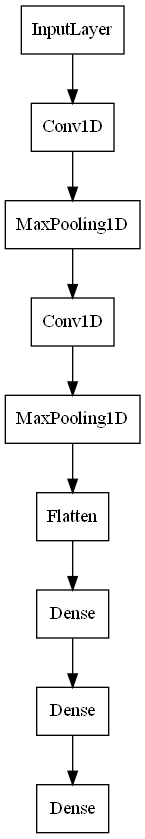

In [20]:
keras.utils.plot_model(model, to_file='imagens/model_cnn.png', show_shapes=False, show_layer_names=False)


In [21]:
model.save('models/cnn')

INFO:tensorflow:Assets written to: models/cnn\assets


INFO:tensorflow:Assets written to: models/cnn\assets
